# How to Train a Deep Neural Network (DNN) Optimally

The goal of training a Deep Artificial Neural Network or DNN is two-fold:

- Achieve effectiveness (such that the model generalizes well)
- Achieve efficiency (converges faster to an effective solution)

We measure the effectiveness by using model's performance on the test dataset (e.g., test accuracy). The efficiency is measured by the training (wall) time. Some techniques enable to converge in fewer epochs, but they require more training time per epoch. For some applications these are not suitable techniques from the perspective of overall training time. 

    We prefer a technique that achieves higher test accuracy using shortest training time.

Two main issues prevent achieving effectiveness and efficiency in training DNNs.

- The vanishing/exploding gradient problem of the Backpropagation algorithm
- Slow convergenge due to the Stochastic Gradient Descent (SGD) algorithm

The first issue is deadlier than the second one. It can completely stall the training and stop learning. Even if the vanishing/exploding gradient issue is resolved, SGD could make the training painfully slow.

We present several techniques to overcome these issues in the following two notebooks designed for **two DNN architectures**:
- Notebook 1: feedforward dense DNNs
- Notebook 2: Convolutional Neural Networks or CNNs



The vanishing/exploding gradient problem of the Backpropagation algorithm is attributed to the weight initialization technique and the activation function. The slow convergence issue of SGD is caused by its learning rate. Thus, we inestigate the role of these three factors in training a DNN optimally:
- Weight Initializer
- Activation Function
- Learning Rate Optimizer for SGD

We use the following variants of the above three factors: 
- Initializers: LeCun, Glorot, He and Orthogonal
- Activation function: Sigmoid, Tanh, ReLU, ELU
- Learning Rate Optimizer: 1cycle (learning rate schedule) to tune global scalar LR & NAdam (adaptive LR) to tune LRs per dimension.

In addition to this, we experiment with the Batch Normalization (BN) technique that addresses the vanishing/exploding gradient poblem as well as acts as a regularizer.

For a fair comparison with the BN based approach, we add l2 regularizer in other models where we see overfitting happens. The regularization parameter alpha is tuned optimally.


## Dense DNN Architecture

We use a dense DNN consisting of 20 hidden layers each having 100 neurons. The size of mini-batches is set to 32. A network is trained for 50 epochs with early stopping on.

## Dataset

We use the CIFAR-10 dataset (Canadian Institute For Advanced Research). It contains 60,000 $32 \times 32$ color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.


## Experiments

We perform following experiments.

1. Experiment 1: LeCun Initializer + Sigmoid Activation + NAdam Optimizer
2. Experiment 2: LeCun Initializer + Tanh Activation + NAdam Optimizer
3. Experiment 3: Glorot Initializer + Tanh Activation + NAdam Optimizer
4. Experiment 4: He Initializer + ReLU Activation + NAdam Optimizer
5. Experiment 5: He Initializer + ELU Activation + NAdam Optimizer
6. Experiment 6: Orthogonal + ELU Activation + NAdam Optimizer
7. Experiment 7: He Initializer + ELU Activation + NAdam Optimizer + BN
8. Experiment 8: Orthogonal Initializer + ELU Activation + 1cycle Learning Schedule
9. Experiment 9: Pretraining Initializer + ELU Activation + 1cycle Learning Schedule


        These experiments are conducted on a GPU from Google Colaboratory.


## Experiment Goal

At the end we want to determine optimal choices for the following three factors that achieve both effectiveness and efficiency in training dense DNNs.

- Weight initializer
- Activation function
- Learning rate setting technique


In [1]:
import warnings
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

## Load the Dataset

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()


X_train = X_train_full[5000:]/1.0
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]/1.0
y_valid = y_train_full[:5000]


print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)

print("\nData type: ", X_train.dtype)
print("Label type: ", y_train.dtype)


Shape of Training Samples:  (45000, 32, 32, 3)
Shape of Training Labels:  (45000, 1)

Shape of Validation Samples:  (5000, 32, 32, 3)
Shape of Validation Labels:  (5000, 1)

Shape of Testing Samples:  (10000, 32, 32, 3)
Shape of Testing Labels:  (10000, 1)

Data type:  float64
Label type:  uint8


## Display a Random Image

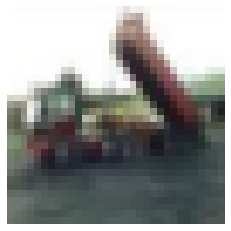

In [3]:
random_digit_image = X_train_full[2]

plt.imshow(random_digit_image, cmap = 'gray', interpolation="nearest")
plt.axis("off")
plt.show()


## Display a Set of Images

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


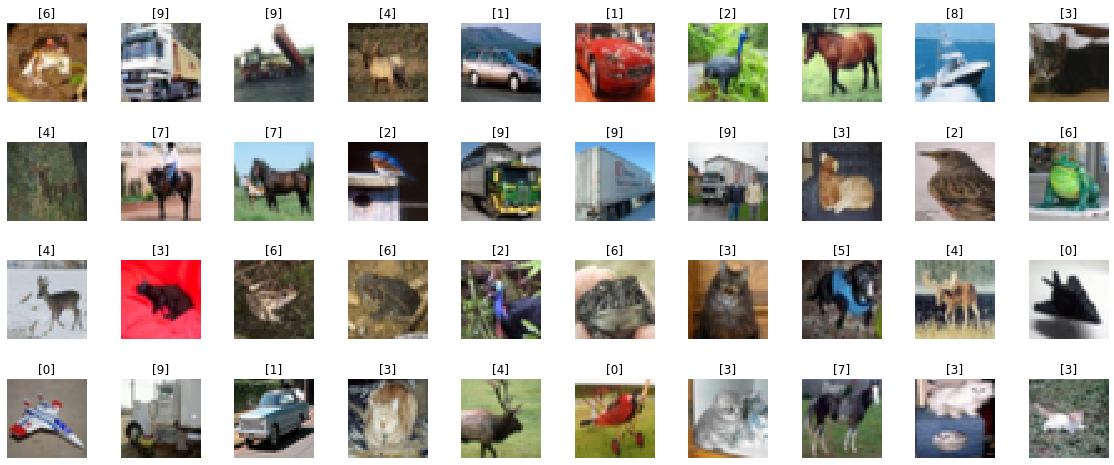

In [4]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 2.0, n_rows * 2.0))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_full[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train_full[index], fontsize=12)

        plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Function For Generating Learning Curves (Accuracy & Loss)

In [5]:
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 

## Function for Plotting Learning Rate and Momentum

In [6]:
# Plot learning rate & momentum
def plot_learning_rate(loss_history_lschedule, numOfEpochs, title, momentumPlot=False):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("Epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("Learning rate")
    
    if(momentumPlot==True):
        plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.mom,'r-', label='momentum')
        plt.ylabel("Learning rate & Momentum")
    
    
    plt.legend(loc=0)
    plt.grid(True)
    plt.title(title)
    plt.show()

## Function to Convert Training Time in Seconds into Hours, Minutes and Seconds

In [7]:
def convertTime(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    if(hour == 0):
        return "{0:2.0f} min {1:2.0f} s".format(minutes, seconds) 
    
    elif(hour == 0 and minutes == 0):
        return "{1:2.0f} s".format(seconds) 
    
    else:
        return "{0:2.0f} h {1:2.0f} min {2:2.0f} s".format(hour, minutes, seconds) 

## Class to store the Changing Loss and Learning Rates

In [8]:
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

## Experiment 1: LeCun Initializer + Sigmoid Activation + NAdam Optimizer

Since the model doesn't overfit, we don't apply any regularizer

In [9]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="sigmoid", kernel_initializer="lecun_normal"))
     
model.add(keras.layers.Dense(10, activation="softmax"))


'''
Define the optimizer
'''
optimizer = keras.optimizers.Nadam(lr=5e-5)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create loss history call back object
'''
loss_history_cb = LossHistory()

model_name = "CIFAR10_LeCun_Sigmoid"
model_name_format = "CIFAR10_LeCun_Sigmoid.h5"

'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)

'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model
'''
no_of_epochs = 100
size_of_mini_batch = 32
t0 = time.time()
history_LeCun_Sigmoid = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_LeCun_Sigmoid_sec = t1-t0
duration_LeCun_Sigmoid = convertTime(duration_LeCun_Sigmoid_sec)
print("\nTraining Time: ", duration_LeCun_Sigmoid)
print("\n")

'''
Save the model
'''
model.save(model_name_format)

Epoch 1/100
1407/1407 [==============================] - 16s 12ms/step - loss: 2.3096 - accuracy: 0.0970 - val_loss: 2.3030 - val_accuracy: 0.0976
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 2.3032 - accuracy: 0.1024 - val_loss: 2.3039 - val_accuracy: 0.0976
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 2.3034 - accuracy: 0.1020 - val_loss: 2.3035 - val_accuracy: 0.1010
Epoch 4/100
1407/1407 [==============================] - 16s 11ms/step - loss: 2.3036 - accuracy: 0.0971 - val_loss: 2.3031 - val_accuracy: 0.0996
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 2.3033 - accuracy: 0.1012 - val_loss: 2.3034 - val_accuracy: 0.1010
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 2.3035 - accuracy: 0.0995 - val_loss: 2.3029 - val_accuracy: 0.0920
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 2.3033 - accuracy: 0.0976 - val_loss: 2

Epochs:  48

CIFAR10_LeCun_Sigmoid Test Accuracy: 0.100
CIFAR10_LeCun_Sigmoid Test Loss: 2.303


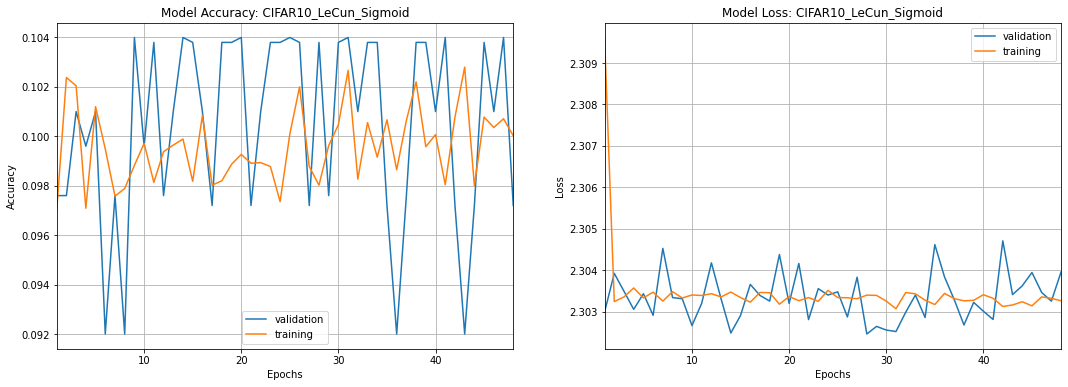

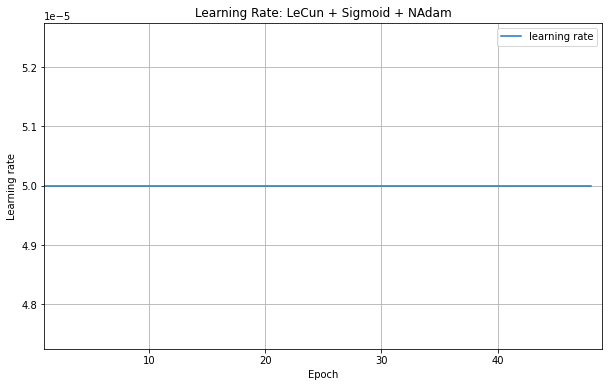

In [10]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)

numOfEpochs_LeCun_Sigmoid = len(history_LeCun_Sigmoid.history['loss'])
print("Epochs: ", numOfEpochs_LeCun_Sigmoid)

test_loss_LeCun_Sigmoid, test_accuracy_LeCun_Sigmoid = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_LeCun_Sigmoid))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_LeCun_Sigmoid))

plot_learning_curves(history_LeCun_Sigmoid, numOfEpochs_LeCun_Sigmoid, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_LeCun_Sigmoid, 
                   "Learning Rate: LeCun + Sigmoid + NAdam", momentumPlot=False)

## Experiment 2: LeCun Initializer + Tanh Activation + NAdam Optimizer

Since the model doesn't overfit, we don't apply any regularizer.

In [11]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="tanh", kernel_initializer="lecun_normal"))
     
model.add(keras.layers.Dense(10, activation="softmax"))


'''
Define the optimizer
'''
optimizer = keras.optimizers.Nadam(lr=5e-5)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create loss history call back object
'''
loss_history_cb = LossHistory()

model_name = "CIFAR10_LeCun_Tanh"
model_name_format = "CIFAR10_LeCun_Tanh.h5"

'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)

'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model
'''
no_of_epochs = 100
size_of_mini_batch = 32
t0 = time.time()
history_LeCun_Tanh = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_LeCun_Tanh_sec = t1-t0
duration_LeCun_Tanh = convertTime(duration_LeCun_Tanh_sec)
print("\nTraining Time: ", duration_LeCun_Tanh)
print("\n")

'''
Save the model
'''
model.save(model_name_format)

Epoch 1/100
1407/1407 [==============================] - 16s 11ms/step - loss: 2.2106 - accuracy: 0.1564 - val_loss: 2.1766 - val_accuracy: 0.1894
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 2.1863 - accuracy: 0.1592 - val_loss: 2.1827 - val_accuracy: 0.1574
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 2.1603 - accuracy: 0.1673 - val_loss: 2.1538 - val_accuracy: 0.1758
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 2.1616 - accuracy: 0.1650 - val_loss: 2.2358 - val_accuracy: 0.1584
Epoch 5/100
1407/1407 [==============================] - 15s 11ms/step - loss: 2.1679 - accuracy: 0.1648 - val_loss: 2.1959 - val_accuracy: 0.1520
Epoch 6/100
1407/1407 [==============================] - 15s 11ms/step - loss: 2.1421 - accuracy: 0.1718 - val_loss: 2.1261 - val_accuracy: 0.1754
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 2.1679 - accuracy: 0.1653 - val_loss: 2

Epochs:  78

CIFAR10_LeCun_Tanh Test Accuracy: 0.277
CIFAR10_LeCun_Tanh Test Loss: 1.973


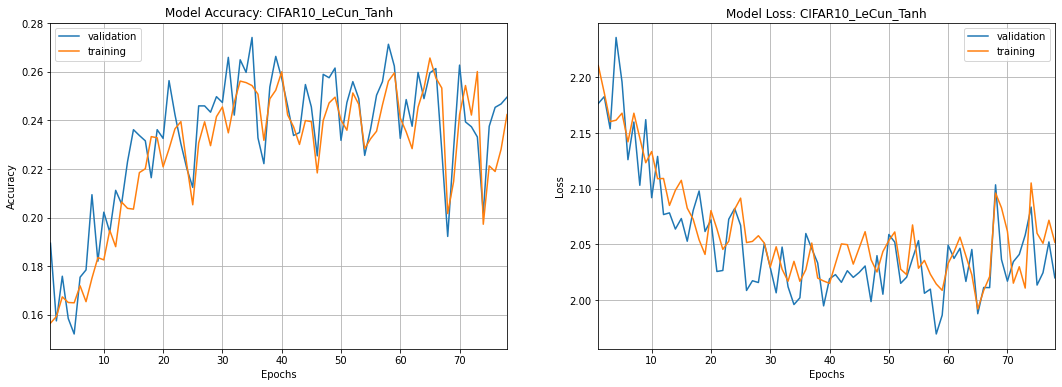

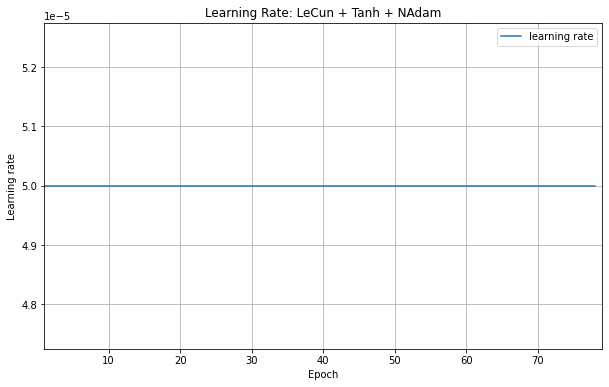

In [12]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)

numOfEpochs_LeCun_Tanh = len(history_LeCun_Tanh.history['loss'])
print("Epochs: ", numOfEpochs_LeCun_Tanh)

test_loss_LeCun_Tanh, test_accuracy_LeCun_Tanh = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_LeCun_Tanh))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_LeCun_Tanh))

plot_learning_curves(history_LeCun_Tanh, numOfEpochs_LeCun_Tanh, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_LeCun_Tanh, 
                   "Learning Rate: LeCun + Tanh + NAdam", momentumPlot=False)

## Experiment 3: Glorot Initializer + Tanh Activation + NAdam Optimizer

Since the model doesn't overfit, we don't apply any regularizer

In [13]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="tanh", kernel_initializer="glorot_normal"))
     
model.add(keras.layers.Dense(10, activation="softmax"))


'''
Define the optimizer
'''
optimizer = keras.optimizers.Nadam(lr=5e-5)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create loss history call back object
'''
loss_history_cb = LossHistory()

model_name = "CIFAR10_Glorot_Tanh"
model_name_format = "CIFAR10_Glorot_Tanh.h5"

'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)

'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model
'''
no_of_epochs = 100
size_of_mini_batch = 32
t0 = time.time()
history_Glorot_Tanh = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_Glorot_Tanh_sec = t1-t0
duration_Glorot_Tanh = convertTime(duration_Glorot_Tanh_sec)
print("\nTraining Time: ", duration_Glorot_Tanh)
print("\n")

'''
Save the model
'''
model.save(model_name_format)

Epoch 1/100
1407/1407 [==============================] - 16s 12ms/step - loss: 2.2110 - accuracy: 0.1617 - val_loss: 2.1775 - val_accuracy: 0.1806
Epoch 2/100
1407/1407 [==============================] - 16s 12ms/step - loss: 2.1731 - accuracy: 0.1720 - val_loss: 2.1530 - val_accuracy: 0.1798
Epoch 3/100
1407/1407 [==============================] - 16s 12ms/step - loss: 2.1413 - accuracy: 0.1928 - val_loss: 2.1488 - val_accuracy: 0.1880
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 2.1395 - accuracy: 0.1971 - val_loss: 2.1318 - val_accuracy: 0.1970
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 2.1165 - accuracy: 0.1993 - val_loss: 2.1134 - val_accuracy: 0.2110
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 2.1371 - accuracy: 0.1836 - val_loss: 2.1058 - val_accuracy: 0.2134
Epoch 7/100
1407/1407 [==============================] - 16s 12ms/step - loss: 2.1111 - accuracy: 0.1988 - val_loss: 2

Epochs:  61

CIFAR10_Glorot_Tanh Test Accuracy: 0.279
CIFAR10_Glorot_Tanh Test Loss: 1.972


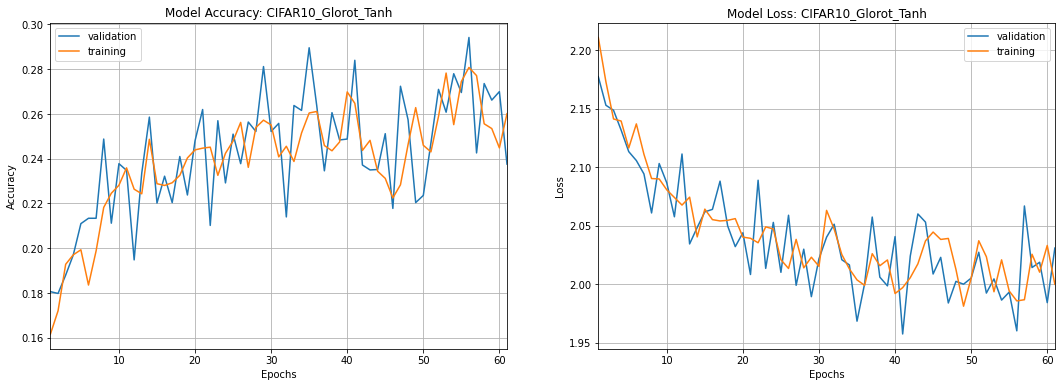

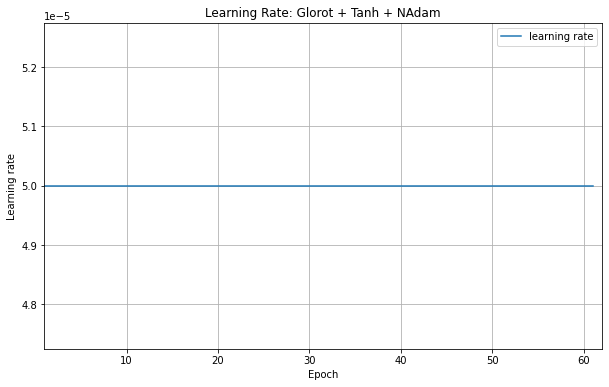

In [14]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)

numOfEpochs_Glorot_Tanh = len(history_Glorot_Tanh.history['loss'])
print("Epochs: ", numOfEpochs_Glorot_Tanh)

test_loss_Glorot_Tanh, test_accuracy_Glorot_Tanh = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Glorot_Tanh))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Glorot_Tanh))

plot_learning_curves(history_Glorot_Tanh, numOfEpochs_Glorot_Tanh, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_Glorot_Tanh, 
                   "Learning Rate: Glorot + Tanh + NAdam", momentumPlot=False)

## Experiment 4: He Initializer + ReLU Activation + NAdam Optimizer + $l_2$ Regularizer

Since this model overfits, we apply the $l_2$ regularizer. We use the optimal value for the regularization hyperparameter $\alpha$.

In [15]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal", 
                                kernel_regularizer=keras.regularizers.l2(0.001)))
    
model.add(keras.layers.Dense(10, activation="softmax"))


'''
Define the optimizer
'''
optimizer = keras.optimizers.Nadam(lr=5e-5)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create loss history call back object
'''
loss_history_cb = LossHistory()

model_name = "CIFAR10_He_ReLU"
model_name_format = "CIFAR10_He_ReLU.h5"

'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)

'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model
'''
no_of_epochs = 100
size_of_mini_batch = 32
t0 = time.time()
history_He_ReLU = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_He_ReLU_sec = t1-t0
duration_He_ReLU = convertTime(duration_He_ReLU_sec)
print("\nTraining Time: ", duration_He_ReLU)
print("\n")

'''
Save the model
'''
model.save(model_name_format)

Epoch 1/100
1407/1407 [==============================] - 18s 13ms/step - loss: 7.6942 - accuracy: 0.1568 - val_loss: 5.7543 - val_accuracy: 0.2016
Epoch 2/100
1407/1407 [==============================] - 17s 12ms/step - loss: 5.5468 - accuracy: 0.2198 - val_loss: 5.4614 - val_accuracy: 0.1980
Epoch 3/100
1407/1407 [==============================] - 17s 12ms/step - loss: 5.1794 - accuracy: 0.2753 - val_loss: 5.0610 - val_accuracy: 0.2834
Epoch 4/100
1407/1407 [==============================] - 18s 12ms/step - loss: 4.8665 - accuracy: 0.3163 - val_loss: 4.8103 - val_accuracy: 0.3136
Epoch 5/100
1407/1407 [==============================] - 17s 12ms/step - loss: 4.5894 - accuracy: 0.3438 - val_loss: 4.4773 - val_accuracy: 0.3416
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 4.3112 - accuracy: 0.3629 - val_loss: 4.1701 - val_accuracy: 0.3696
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 4.0362 - accuracy: 0.3808 - val_loss: 3

Epochs:  89

CIFAR10_He_ReLU Test Accuracy: 0.501
CIFAR10_He_ReLU Test Loss: 2.231


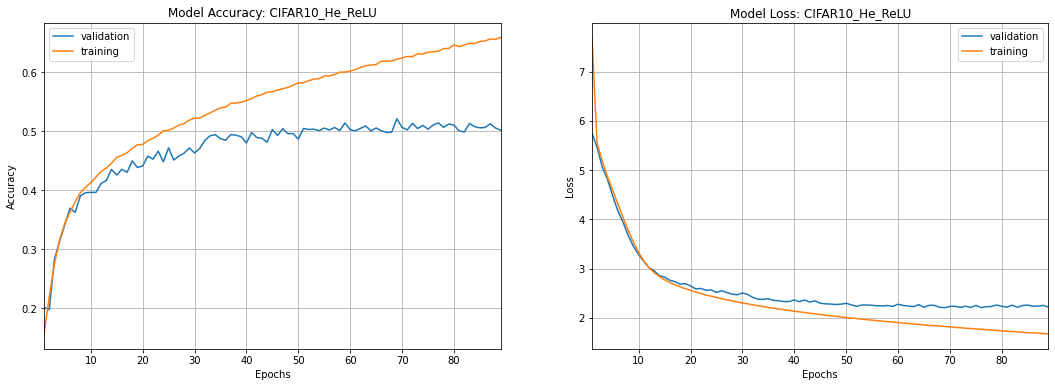

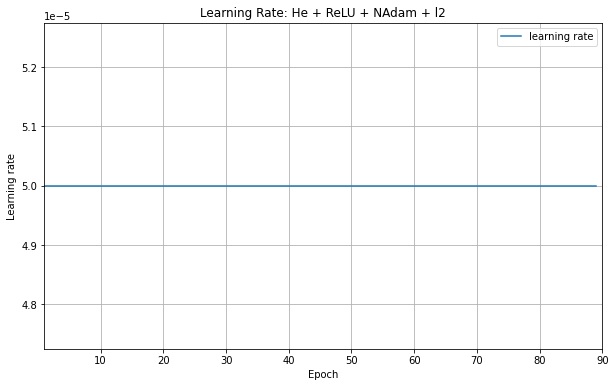

In [16]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)

numOfEpochs_He_ReLU = len(history_He_ReLU.history['loss'])
print("Epochs: ", numOfEpochs_He_ReLU)

test_loss_He_ReLU, test_accuracy_He_ReLU = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_He_ReLU))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_He_ReLU))

plot_learning_curves(history_He_ReLU, numOfEpochs_He_ReLU, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_He_ReLU, 
                   "Learning Rate: He + ReLU + NAdam + l2", momentumPlot=False)

## Experiment 5: He Initializer + ELU Activation + NAdam Optimizer + $l_2$ Regularizer

Since this model overfits, we apply the $l_2$ regularizer. We use the optimal value for the regularization hyperparameter $\alpha$.

In [17]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", 
                                kernel_regularizer=keras.regularizers.l2(0.001)))
    
model.add(keras.layers.Dense(10, activation="softmax"))


'''
Define the optimizer
'''
optimizer = keras.optimizers.Nadam(lr=5e-5)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create loss history call back object
'''
loss_history_cb = LossHistory()

model_name = "CIFAR10_He_ELU"
model_name_format = "CIFAR10_He_ELU.h5"

'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)

'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model
'''
no_of_epochs = 100
size_of_mini_batch = 32
t0 = time.time()
history_He_ELU = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_He_ELU_sec = t1-t0
duration_He_ELU = convertTime(duration_He_ELU_sec)
print("\nTraining Time: ", duration_He_ELU)
print("\n")

'''
Save the model
'''
model.save(model_name_format)

Epoch 1/100
1407/1407 [==============================] - 18s 13ms/step - loss: 7.9092 - accuracy: 0.1614 - val_loss: 5.9157 - val_accuracy: 0.2212
Epoch 2/100
1407/1407 [==============================] - 17s 12ms/step - loss: 5.7488 - accuracy: 0.2422 - val_loss: 5.6071 - val_accuracy: 0.2476
Epoch 3/100
1407/1407 [==============================] - 17s 12ms/step - loss: 5.4237 - accuracy: 0.2926 - val_loss: 5.3790 - val_accuracy: 0.2826
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 5.1401 - accuracy: 0.3262 - val_loss: 5.0816 - val_accuracy: 0.3244
Epoch 5/100
1407/1407 [==============================] - 18s 13ms/step - loss: 4.8649 - accuracy: 0.3562 - val_loss: 4.7456 - val_accuracy: 0.3496
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 4.5919 - accuracy: 0.3792 - val_loss: 4.4955 - val_accuracy: 0.3724
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 4.3246 - accuracy: 0.3956 - val_loss: 4

Epochs:  91

CIFAR10_He_ELU Test Accuracy: 0.505
CIFAR10_He_ELU Test Loss: 2.336


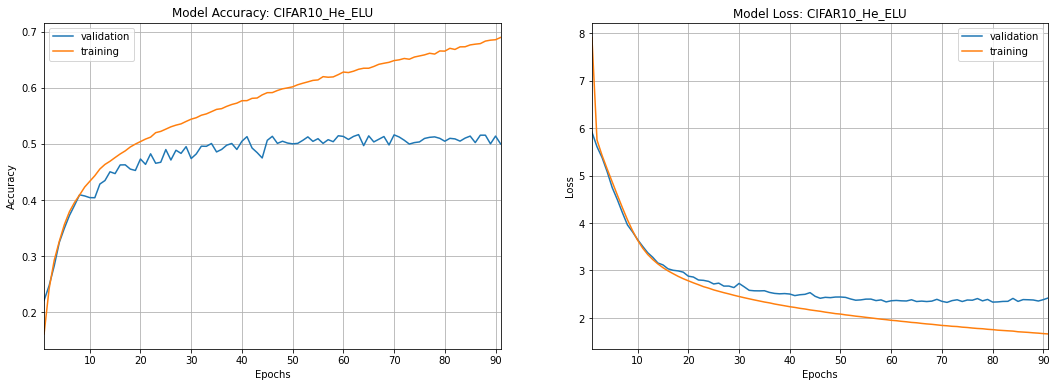

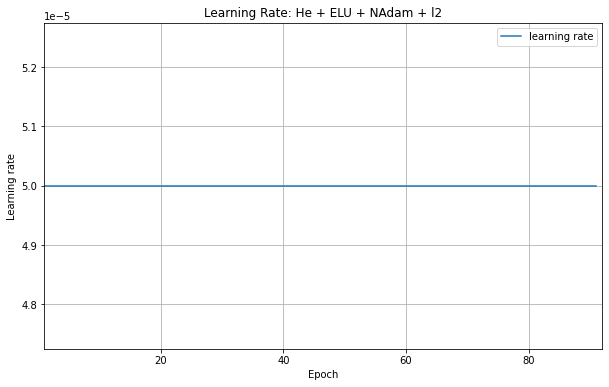

In [18]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)

numOfEpochs_He_ELU = len(history_He_ELU.history['loss'])
print("Epochs: ", numOfEpochs_He_ELU)

test_loss_He_ELU, test_accuracy_He_ELU = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_He_ELU))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_He_ELU))

plot_learning_curves(history_He_ELU, numOfEpochs_He_ELU, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_He_ELU, 
                   "Learning Rate: He + ELU + NAdam + l2", momentumPlot=False)

## Experiment 6: Orthogonal + ELU Activation + NAdam Optimizer + $l_2$ Regularizer

Since this model overfits, we apply the $l_2$ regularizer. We use the optimal value for the regularization hyperparameter $\alpha$.

In [19]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer=orthogonal_init, 
                                 kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dense(10, activation="softmax"))


'''
Define the optimizer
'''
optimizer = keras.optimizers.Nadam(lr=5e-5)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create loss history call back object
'''
loss_history_cb = LossHistory()

model_name = "CIFAR10_Orthogonal_ELU"
model_name_format = "CIFAR10_Orthogonal_ELU.h5"

'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)

'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model
'''
no_of_epochs = 100
size_of_mini_batch = 32
t0 = time.time()
history_Orthogonal_ELU = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_Orthogonal_ELU_sec = t1-t0
duration_Orthogonal_ELU = convertTime(duration_Orthogonal_ELU_sec)
print("\nTraining Time: ", duration_Orthogonal_ELU)
print("\n")

'''
Save the model
'''
model.save(model_name_format)

Epoch 1/100
1407/1407 [==============================] - 18s 13ms/step - loss: 3.7298 - accuracy: 0.3129 - val_loss: 3.5090 - val_accuracy: 0.3492
Epoch 2/100
1407/1407 [==============================] - 18s 13ms/step - loss: 3.3307 - accuracy: 0.3896 - val_loss: 3.2376 - val_accuracy: 0.3924
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 3.1207 - accuracy: 0.4189 - val_loss: 3.1776 - val_accuracy: 0.3876
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 2.9811 - accuracy: 0.4414 - val_loss: 3.0816 - val_accuracy: 0.3986
Epoch 5/100
1407/1407 [==============================] - 18s 13ms/step - loss: 2.8736 - accuracy: 0.4565 - val_loss: 2.8764 - val_accuracy: 0.4348
Epoch 6/100
1407/1407 [==============================] - 18s 13ms/step - loss: 2.7881 - accuracy: 0.4657 - val_loss: 2.8442 - val_accuracy: 0.4378
Epoch 7/100
1407/1407 [==============================] - 18s 13ms/step - loss: 2.7151 - accuracy: 0.4763 - val_loss: 2

Epochs:  73

CIFAR10_Orthogonal_ELU Test Accuracy: 0.518
CIFAR10_Orthogonal_ELU Test Loss: 2.094


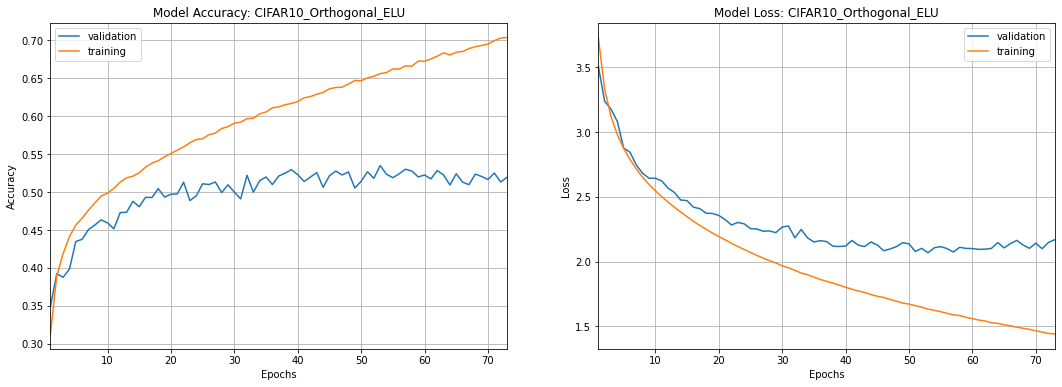

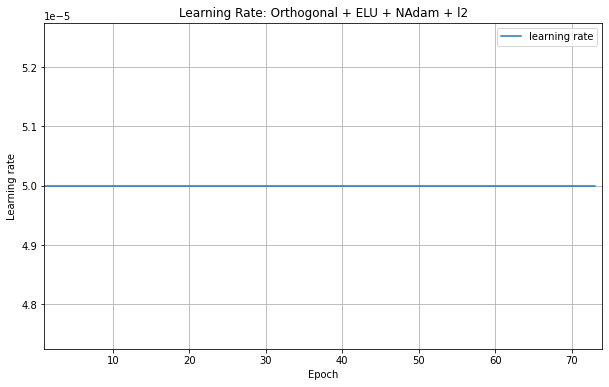

In [20]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)

numOfEpochs_Orthogonal_ELU = len(history_Orthogonal_ELU.history['loss'])
print("Epochs: ", numOfEpochs_Orthogonal_ELU)

test_loss_Orthogonal_ELU, test_accuracy_Orthogonal_ELU = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Orthogonal_ELU))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Orthogonal_ELU))

plot_learning_curves(history_Orthogonal_ELU, numOfEpochs_Orthogonal_ELU, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_Orthogonal_ELU, 
                   "Learning Rate: Orthogonal + ELU + NAdam + l2", momentumPlot=False)

## Experiment 7: He Initializer + ELU Activation + NAdam Optimizer + BN


In [21]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))    
model.add(keras.layers.Dense(10, activation="softmax"))


'''
Define the optimizer
'''
optimizer = keras.optimizers.Nadam(lr=5e-5)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create loss history call back object
'''
loss_history_cb = LossHistory()

model_name = "CIFAR10_He_ELU_BN"
model_name_format = "CIFAR10_He_ELU_BN.h5"

'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)

'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model
'''
no_of_epochs = 100
size_of_mini_batch = 32
t0 = time.time()
history_He_ELU_BN = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb,
                               early_stopping_cb, loss_history_cb])
t1 = time.time()

duration_He_ELU_BN_sec = t1-t0
duration_He_ELU_BN = convertTime(duration_He_ELU_BN_sec)
print("\nTraining Time: ", duration_He_ELU_BN)
print("\n")

'''
Save the model
'''
model.save(model_name_format)

Epoch 1/100
1407/1407 [==============================] - 40s 29ms/step - loss: 2.0313 - accuracy: 0.2755 - val_loss: 1.7652 - val_accuracy: 0.3672
Epoch 2/100
1407/1407 [==============================] - 39s 28ms/step - loss: 1.7800 - accuracy: 0.3639 - val_loss: 1.6478 - val_accuracy: 0.4076
Epoch 3/100
1407/1407 [==============================] - 39s 28ms/step - loss: 1.6921 - accuracy: 0.3986 - val_loss: 1.5771 - val_accuracy: 0.4326
Epoch 4/100
1407/1407 [==============================] - 39s 28ms/step - loss: 1.6322 - accuracy: 0.4190 - val_loss: 1.5234 - val_accuracy: 0.4588
Epoch 5/100
1407/1407 [==============================] - 39s 28ms/step - loss: 1.5874 - accuracy: 0.4355 - val_loss: 1.4945 - val_accuracy: 0.4662
Epoch 6/100
1407/1407 [==============================] - 39s 28ms/step - loss: 1.5524 - accuracy: 0.4487 - val_loss: 1.4681 - val_accuracy: 0.4644
Epoch 7/100
1407/1407 [==============================] - 39s 28ms/step - loss: 1.5199 - accuracy: 0.4620 - val_loss: 1

Epochs:  46

CIFAR10_He_ELU_BN Test Accuracy: 0.522
CIFAR10_He_ELU_BN Test Loss: 1.359


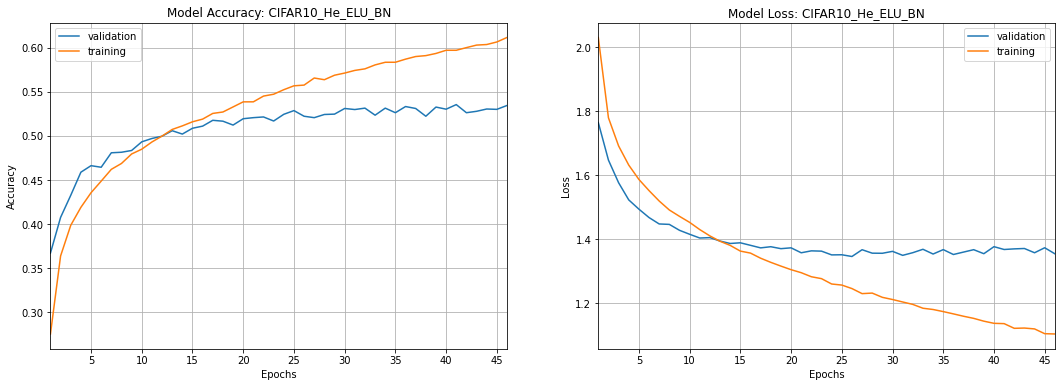

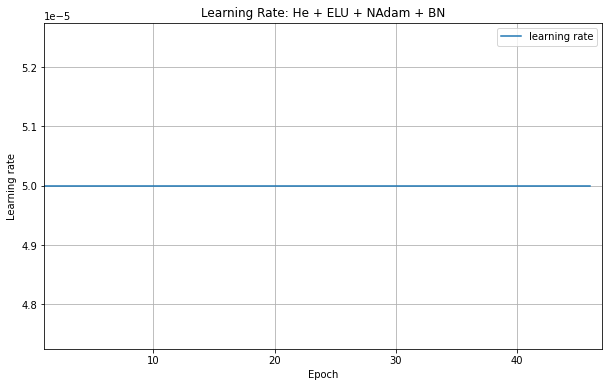

In [22]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)

numOfEpochs_He_ELU_BN = len(history_He_ELU_BN.history['loss'])
print("Epochs: ", numOfEpochs_He_ELU_BN)

test_loss_He_ELU_BN, test_accuracy_He_ELU_BN = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_He_ELU_BN))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_He_ELU_BN))

plot_learning_curves(history_He_ELU_BN, numOfEpochs_He_ELU_BN, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_He_ELU_BN, 
                   "Learning Rate: He + ELU + NAdam + BN", momentumPlot=False)

## Experiment 8: Orthogonal Initializer + ELU Activation + 1cycle Learning Schedule + $l_2$ Regularizer

Since this model overfits, we apply the $l_2$ regularizer. We use the optimal value for the regularization hyperparameter $\alpha$.

To use the 1cycle learning schedule we need to find the maximum learning rate first.

### Heuristic to Find the Maximum Learning Rate for 1cycle Schedule

To find the maximum learning rate for 1cycle, we train the network for a few epochs and grow the learning rate at each iteration. We start from a very small learning rate and increase up to a very large learning rate. Then, by observing the change in loss at each iteration we find the maximum learning rate that provides minimum loss.

To increase the learning rate by a constant factor we define the following class.

In [23]:
'''
A class to increase the learning rate by a "factor" at each iteration.
It stores the changing learning rate and loss at each iteration.
'''

K = keras.backend

class IncreaseLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
   

        
'''
Function to determine the "factor" to be used in the IncreaseLearningRate (above) object
'''
def computeFactorForIncreasingLearningRate(X, size_mini_batch, no_of_epochs, upper_bound_lr, lower_bound_lr):
    
    # Total number of iterations
    iterations = len(X) // size_mini_batch * no_of_epochs
    
    factor = np.exp(np.log(upper_bound_lr / lower_bound_lr) / iterations)
    
    return factor

### Finding the Maximum Learning Rate for 1cycle Schedule

First, we build the DNN.

Then, we create an IncreaseLearningRate object (class defined above). At each iteration it increases the learning rate by a factor determined by the computeFactorForIncreasingLearningRate function. We pass this object as a callback to the fit() method of the model.

At the completion of training (for a few epochs), we use the loss vs. learning rate plot to find the maximum learning rate for 1cycle schedule.

In [24]:
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)


# Build the sequential DNN model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer=orthogonal_init))
model.add(keras.layers.Dense(10, activation="softmax"))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 32
no_of_epochs = 1
upper_bound_lr = 10
lower_bound_lr = 1e-5
increase_factor = computeFactorForIncreasingLearningRate(X_train, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

1407/1407 [==============================] - 7s 5ms/step - loss: nan - accuracy: 0.1199 - val_loss: nan - val_accuracy: 0.1010


### Plot the Loss as a Function of the Learning Rate

To create the plot for learning rate vs loss, we consider two things.

1. Since the increase in loss is much higher for larger learning rates, the plot will be skewed toward max_lr. The difference in loss for smaller learning rates will be compressed, hence difficult to distinguish. That's why we use log scale for the learning rate (i.e., log scale for x-axis).

        To implement the log scale, we use two things:
    
            -- The gcf() function to get the current Axes instance on the current figure matching the given keyword args.
            -- The Axes.set_xscale function to change the scale after the Axes object is created.


2. The upper limit of the y-axis (loss) need to be set carefully. If we use the maximum loss as the upper limit, then again the plot will be skewed. Since initially (for the min_lr) loss is reasonably large, but not as large as it is for max_lr, we can use the loss at min_lr to be the upper limit for y-axis. We tweak it a little bit for more clarity.

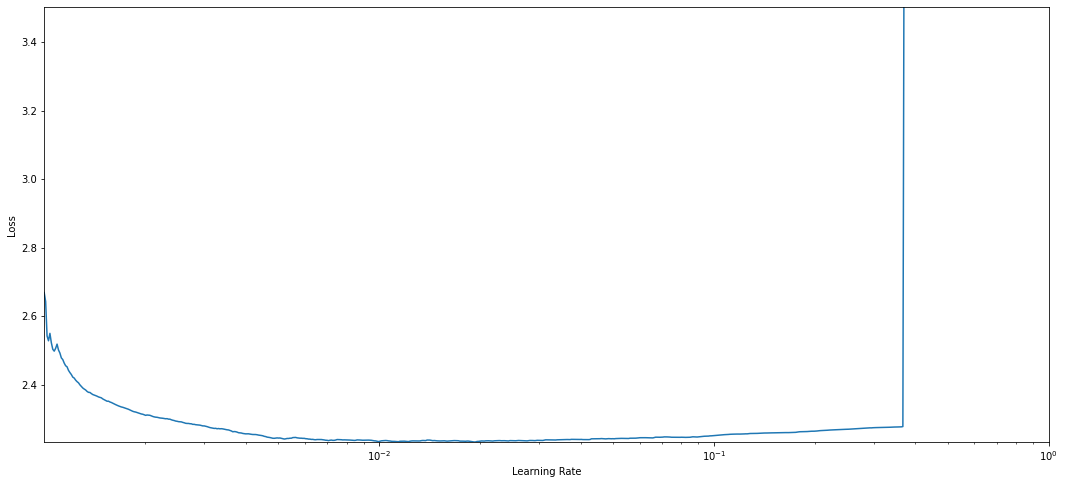

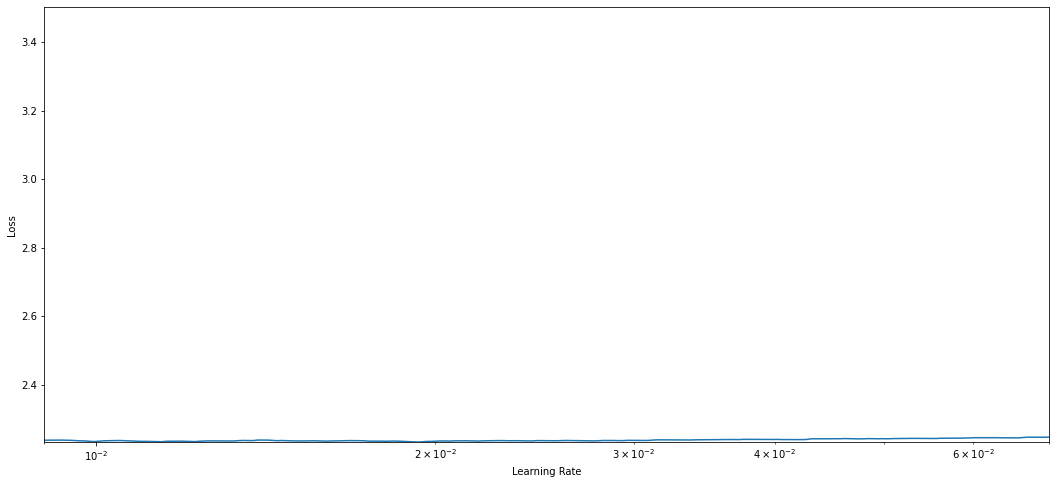

In [29]:
plt.figure(figsize = (18,8))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


'''
For clarity we zoom into a small range of the plot
'''

plt.figure(figsize = (18,8))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.009, 0.07)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

### Maximum Learning Rate for 1cycle Schedule

We see that the loss starts increasing with large oscillation right after the learning rate 0.03. Thus, we use 0.02 as our maximum learning rate.

It is used to create the OneCycle object (set the value of the argument "max_rate").

In [30]:
class OneCycle(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, momentum_vals=(0.95, 0.85), start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
        self.step_len =  int(self.iterations * (1 - 10.0/100.0)/2)
        
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        
        # Set Learning Rate
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
        
        
        # Set Momentum
        if self.iteration == 0:
            return self.high_mom
        elif self.iteration == self.iterations:
            self.iteration = 0
            return self.high_mom
        elif self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration - self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        K.set_value(self.model.optimizer.momentum, mom)

        
        
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory_OneCycle(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.mom = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))
        self.mom.append(K.get_value(self.model.optimizer.momentum))

## Experiment 8:  Train the Model using the 1cycle Learning Schedule with the Obtained Max Learning Rate

In [31]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential()


model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer=orthogonal_init,
                                 kernel_regularizer=keras.regularizers.l2(0.001)))
                                 
model.add(keras.layers.Dense(10, activation="softmax"))


'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_Orthogonal_ELU_1cycle"
model_name_format = "CIFAR10_Orthogonal_ELU_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 50
size_of_mini_batch = 32
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.02, momentum_vals=(0.9, 0.8))


t0 = time.time()
history_Orthogonal_ELU_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               early_stopping_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_Orthogonal_ELU_1cycle_sec = t1-t0
duration_Orthogonal_ELU_1cycle = convertTime(duration_Orthogonal_ELU_1cycle_sec)
print("\nTraining Time: ", duration_Orthogonal_ELU_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/50
1407/1407 [==============================] - 11s 7ms/step - loss: 3.9593 - accuracy: 0.2768 - val_loss: 3.8576 - val_accuracy: 0.3098
Epoch 2/50
1407/1407 [==============================] - 10s 7ms/step - loss: 3.7643 - accuracy: 0.3491 - val_loss: 3.8151 - val_accuracy: 0.3198
Epoch 3/50
1407/1407 [==============================] - 10s 7ms/step - loss: 3.6585 - accuracy: 0.3735 - val_loss: 3.9463 - val_accuracy: 0.2912
Epoch 4/50
1407/1407 [==============================] - 10s 7ms/step - loss: 3.5659 - accuracy: 0.3946 - val_loss: 4.3817 - val_accuracy: 0.2096
Epoch 5/50
1407/1407 [==============================] - 10s 7ms/step - loss: 3.4808 - accuracy: 0.4063 - val_loss: 3.5085 - val_accuracy: 0.3782
Epoch 6/50
1407/1407 [==============================] - 10s 7ms/step - loss: 3.3978 - accuracy: 0.4161 - val_loss: 3.4091 - val_accuracy: 0.4048
Epoch 7/50
1407/1407 [==============================] - 10s 7ms/step - loss: 3.3074 - accuracy: 0.4319 - val_loss: 3.3757 - val_ac

Epochs:  50

CIFAR10_Orthogonal_ELU_1cycle Test Accuracy: 0.517
CIFAR10_Orthogonal_ELU_1cycle Test Loss: 1.835


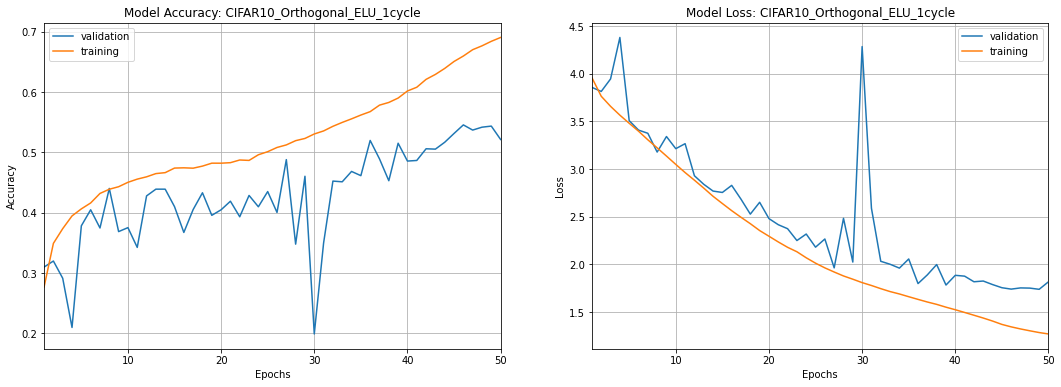

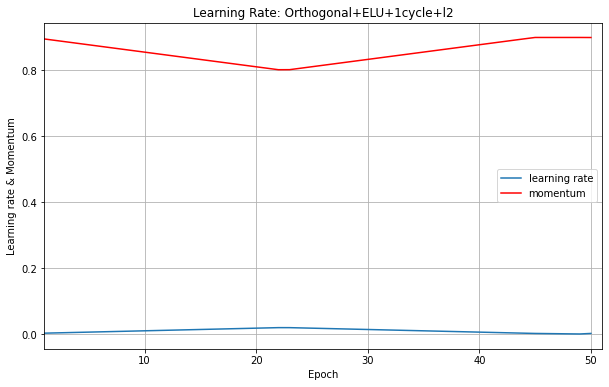

In [32]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)

numOfEpochs_Orthogonal_ELU_1cycle = len(history_Orthogonal_ELU_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_Orthogonal_ELU_1cycle)

test_loss_Orthogonal_ELU_1cycle, test_accuracy_Orthogonal_ELU_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Orthogonal_ELU_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Orthogonal_ELU_1cycle))

plot_learning_curves(history_Orthogonal_ELU_1cycle, numOfEpochs_Orthogonal_ELU_1cycle, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_Orthogonal_ELU_1cycle, 
                   "Learning Rate: Orthogonal+ELU+1cycle+l2", momentumPlot=True)

##  Experiment 9: Pretraining Initializer + ELU Activation + 1cycle Learning Schedule + $l_2$ Regularizer



In this experiment we initialize the weights of the DNN via pretraining. We use a small subset of the training data (with only 2 classes) to train the DNN architecture. Then, using the pretrained layers (except the final layer) as initial weights, we train the DNN using full training data. There are two steps in this pretraining based initialization approach:

- Step 1: Initialize weights by pretraining using a smaller training data
- Step 2: Fine-tune using full training data

For the pretraining part, we use the orthogonal weight initializer and ELU activation function. The model is regularized by $l_2$ regularizer. We use the optimal value for the regularization hyperparameter $\alpha$ for pretrining weights as well as during fine-tuning.

We set the SGD learning rate using the 1cycle learning schedule. For this, first we find the maximum learning rate. Then, using the maximum learning rate for 1cycle schedule we pretrain the model.

For the fine-tuning, we use the weights of the hidden layers of the pretrained model and add the output layer. We use the same maximum learning rate for 1cycle learning schedule to train the model.


## Create Small Training & Validation Set
We use 1/5 of the labels to create a smaller training and validation dataset. Effectively the training set is reduced by a factor of 5.

For this experiment, we only use the first two classes for pretraining. For these two classes all training data are used.

In [33]:
count_few_labels = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == 0 or y_train[i] == 1):
        count_few_labels += 1
    

X_train_small = np.zeros((count_few_labels, 32,32,3), 'float64')
y_train_small = np.zeros((count_few_labels, 1), 'uint8')

j = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == 0 or y_train[i] == 1):
        X_train_small[j] = X_train[i]
        y_train_small[j] = y_train[i]
        j += 1
        
        
print("\nShape of Small Training Samples: ", X_train_small.shape)
print("Shape of Small Training Labels: ", y_train_small.shape)


Shape of Small Training Samples:  (9035, 32, 32, 3)
Shape of Small Training Labels:  (9035, 1)


In [34]:
count_few_labels_valid = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == 0 or y_valid[i] == 1):
        count_few_labels_valid += 1
    

X_valid_small = np.zeros((count_few_labels_valid, 32,32,3), 'float64')

y_valid_small = np.zeros((count_few_labels_valid, 1), 'uint8')

j = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == 0 or y_valid[i] == 1):
        X_valid_small[j] = X_valid[i]
        y_valid_small[j] = y_valid[i]
        j += 1
        
        
print("\nShape of Small Validation Samples: ", X_valid_small.shape)
print("Shape of Small Validation Labels: ", y_valid_small.shape)


Shape of Small Validation Samples:  (965, 32, 32, 3)
Shape of Small Validation Labels:  (965, 1)


## Pretraining: Find Maximum Learning Rate for 1cycle Schedule

In [35]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer=orthogonal_init,
                                 kernel_regularizer=keras.regularizers.l2(0.001)))
    
model.add(keras.layers.Dense(10, activation="softmax"))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 32
no_of_epochs = 1
upper_bound_lr = 10
lower_bound_lr = 1e-5
increase_factor = computeFactorForIncreasingLearningRate(X_train_small, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train_small, y_train_small, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[increase_lr_cb])

283/283 [==============================] - 2s 8ms/step - loss: nan - accuracy: 0.5067 - val_loss: nan - val_accuracy: 0.5233
CPU times: user 3.79 s, sys: 287 ms, total: 4.07 s
Wall time: 3.49 s


## Plot the Loss as a Function of the Learning Rate

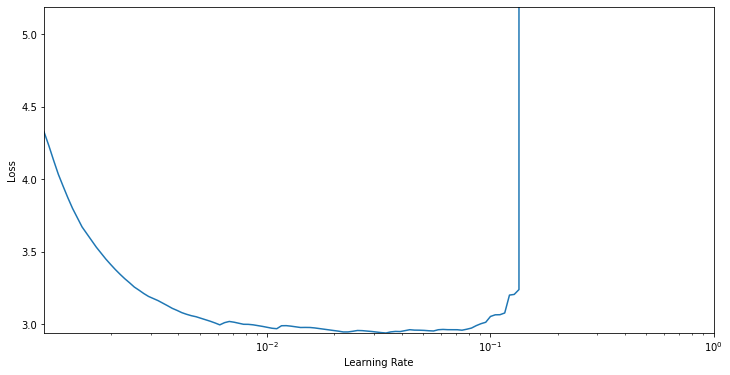

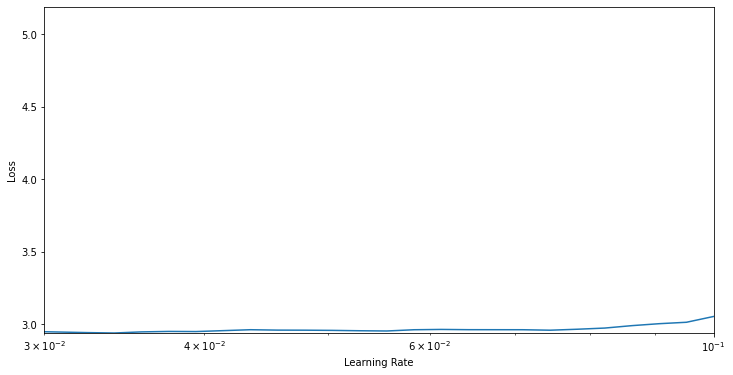

In [37]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


'''
For clarity we zoom into a small range
'''

plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.03, 0.1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Maximum Learning Rate of Pretraining 1cycle Schedule

We see that the maximum learning rate is 0.035.



## Pretrain The Model

In [38]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model_pretrained = keras.models.Sequential()


model_pretrained.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
    model_pretrained.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer=orthogonal_init,
                                 kernel_regularizer=keras.regularizers.l2(0.001)))
                                 
model_pretrained.add(keras.layers.Dense(10, activation="softmax"))


'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model_pretrained.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_Pretraining_1cycle"
model_name_format = "CIFAR10_Pretraining_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 50
size_of_mini_batch = 32
no_iterations = (len(X_train_small) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.035, momentum_vals=(0.9, 0.8))


t0 = time.time()
history_Pretraining_1cycle = model_pretrained.fit(X_train_small, y_train_small, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               early_stopping_cb, loss_history_oneCycle_cb])
t1 = time.time()



duration_Pretraining_1cycle_sec = t1-t0
duration_Pretraining_1cycle = convertTime(duration_Pretraining_1cycle_sec)
print("\nTraining Time: ", duration_Pretraining_1cycle)
print("\n")


model_pretrained.save(model_name_format)

Epoch 1/50
283/283 [==============================] - 3s 9ms/step - loss: 2.6172 - accuracy: 0.6914 - val_loss: 3.0976 - val_accuracy: 0.5005
Epoch 2/50
283/283 [==============================] - 2s 7ms/step - loss: 2.4898 - accuracy: 0.7657 - val_loss: 2.4350 - val_accuracy: 0.7782
Epoch 3/50
283/283 [==============================] - 2s 7ms/step - loss: 2.4403 - accuracy: 0.7835 - val_loss: 2.3949 - val_accuracy: 0.8031
Epoch 4/50
283/283 [==============================] - 2s 7ms/step - loss: 2.4024 - accuracy: 0.7941 - val_loss: 2.3127 - val_accuracy: 0.8383
Epoch 5/50
283/283 [==============================] - 2s 7ms/step - loss: 2.3701 - accuracy: 0.8035 - val_loss: 2.3033 - val_accuracy: 0.8197
Epoch 6/50
283/283 [==============================] - 2s 7ms/step - loss: 2.3344 - accuracy: 0.8115 - val_loss: 2.2942 - val_accuracy: 0.8166
Epoch 7/50
283/283 [==============================] - 2s 7ms/step - loss: 2.2983 - accuracy: 0.8179 - val_loss: 2.2442 - val_accuracy: 0.8466
Epoch 

## Transfer Weights From the Pretrained Model

In [39]:
#model_pretrained = keras.models.load_model("CIFAR10_Pretraining_1cycle.h5")

model_pretrained_clone = keras.models.clone_model(model_pretrained)
model_pretrained_clone.set_weights(model_pretrained.get_weights())

# Transfer the weights from the pretrained model except the final layer
model = keras.models.Sequential(model_pretrained.layers[:-1])

# Add the final layer
model.add(keras.layers.Dense(10, activation="softmax"))

## Fine-Tune the Pretrained Model

In [40]:
'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_FineTuning_1cycle"
model_name_format = "CIFAR10_FineTuning_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 50
size_of_mini_batch = 32
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.035, momentum_vals=(0.9, 0.8))


t0 = time.time()
history_FineTuning_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               early_stopping_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_FineTuning_1cycle_sec = t1-t0
duration_FineTuning_1cycle = convertTime(duration_FineTuning_1cycle_sec)
print("\nTraining Time: ", duration_FineTuning_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/50
1407/1407 [==============================] - 10s 7ms/step - loss: 2.9001 - accuracy: 0.1967 - val_loss: 2.8136 - val_accuracy: 0.2264
Epoch 2/50
1407/1407 [==============================] - 10s 7ms/step - loss: 2.7370 - accuracy: 0.2538 - val_loss: 2.9493 - val_accuracy: 0.2348
Epoch 3/50
1407/1407 [==============================] - 10s 7ms/step - loss: 2.6238 - accuracy: 0.2945 - val_loss: 2.6881 - val_accuracy: 0.2812
Epoch 4/50
1407/1407 [==============================] - 10s 7ms/step - loss: 2.5386 - accuracy: 0.3156 - val_loss: 3.1606 - val_accuracy: 0.1726
Epoch 5/50
1407/1407 [==============================] - 10s 7ms/step - loss: 2.4676 - accuracy: 0.3429 - val_loss: 2.5883 - val_accuracy: 0.3036
Epoch 6/50
1407/1407 [==============================] - 10s 7ms/step - loss: 2.4140 - accuracy: 0.3572 - val_loss: 2.5578 - val_accuracy: 0.3292
Epoch 7/50
1407/1407 [==============================] - 10s 7ms/step - loss: 2.3584 - accuracy: 0.3679 - val_loss: 2.3485 - val_ac

Epochs:  50

CIFAR10_FineTuning_1cycle Test Accuracy: 0.488
CIFAR10_FineTuning_1cycle Test Loss: 1.742


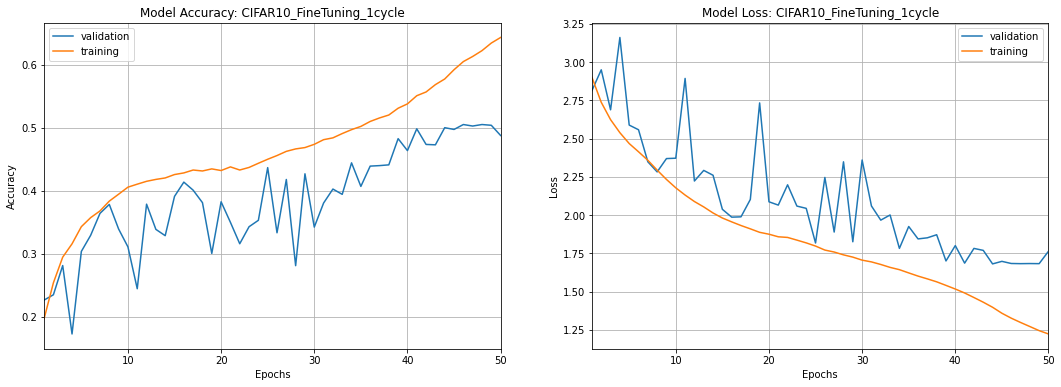

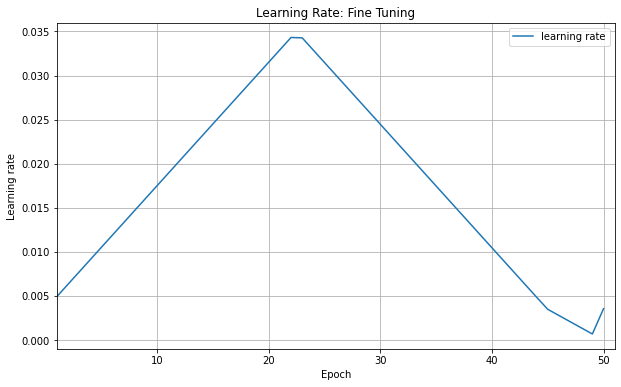

In [41]:
# Load the saved model for making predictions
#model = keras.models.load_model(model_name_format)

numOfEpochs_FineTuning_1cycle = len(history_FineTuning_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_FineTuning_1cycle)

test_loss_FineTuning_1cycle, test_accuracy_FineTuning_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_FineTuning_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_FineTuning_1cycle))

plot_learning_curves(history_FineTuning_1cycle, numOfEpochs_FineTuning_1cycle, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_FineTuning_1cycle, 
                   "Learning Rate: Fine Tuning", momentumPlot=False)

## Comparison of Validation Accuracy Over Epochs

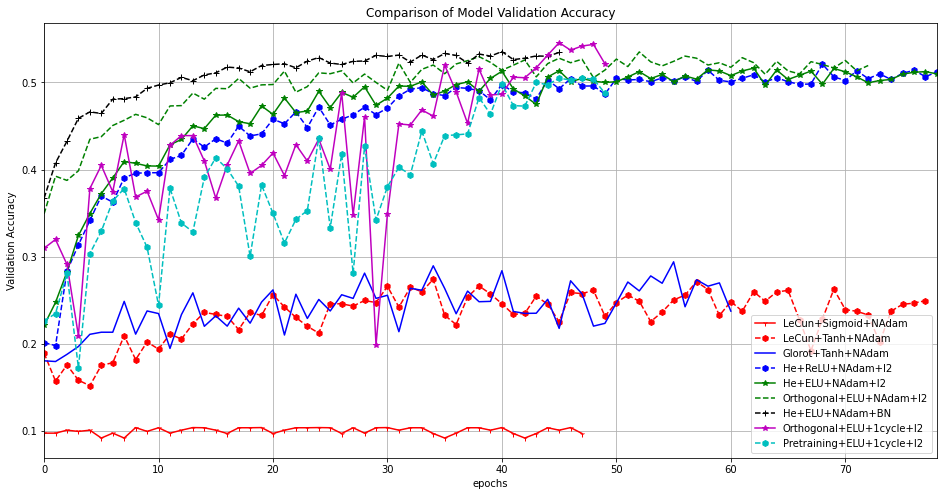

In [42]:
epochs = max(numOfEpochs_LeCun_Sigmoid, numOfEpochs_LeCun_Tanh)

plt.figure(figsize=(16,8))
plt.plot(range(numOfEpochs_LeCun_Sigmoid),history_LeCun_Sigmoid.history['val_accuracy'],'r1-',
         label='LeCun+Sigmoid+NAdam')

plt.plot(range(numOfEpochs_LeCun_Tanh),history_LeCun_Tanh.history['val_accuracy'],'rh--',
         label='LeCun+Tanh+NAdam')

plt.plot(range(numOfEpochs_Glorot_Tanh),history_Glorot_Tanh.history['val_accuracy'],'b-',
         label='Glorot+Tanh+NAdam')


plt.plot(range(numOfEpochs_He_ReLU),history_He_ReLU.history['val_accuracy'],'bh--',
         label='He+ReLU+NAdam+l2')


plt.plot(range(numOfEpochs_He_ELU),history_He_ELU.history['val_accuracy'],'g*-',
         label='He+ELU+NAdam+l2')


plt.plot(range(numOfEpochs_Orthogonal_ELU),history_Orthogonal_ELU.history['val_accuracy'],'g--',
         label='Orthogonal+ELU+NAdam+l2')


plt.plot(range(numOfEpochs_He_ELU_BN),history_He_ELU_BN.history['val_accuracy'],'k+--',
         label='He+ELU+NAdam+BN')


plt.plot(range(numOfEpochs_Orthogonal_ELU_1cycle),history_Orthogonal_ELU_1cycle.history['val_accuracy'],'m*-',
         label='Orthogonal+ELU+1cycle+l2')


plt.plot(range(numOfEpochs_FineTuning_1cycle),history_FineTuning_1cycle.history['val_accuracy'],'ch--',
         label='Pretraining+ELU+1cycle+l2')

plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title("Comparison of Model Validation Accuracy")
plt.show()


## Comparison of Test Accuracy and Total Number of Epochs

In [43]:
data = [
    ["LeCun+Sigmoid+NAdam", numOfEpochs_LeCun_Sigmoid, duration_LeCun_Sigmoid, test_accuracy_LeCun_Sigmoid],
    ["LeCun+Tanh+NAdam", numOfEpochs_LeCun_Tanh, duration_LeCun_Tanh, test_accuracy_LeCun_Tanh],
    ["Glorot+Tanh+NAdam", numOfEpochs_Glorot_Tanh, duration_Glorot_Tanh, test_accuracy_Glorot_Tanh],
    ["He+ReLU+NAdam+l2", numOfEpochs_He_ReLU, duration_He_ReLU, test_accuracy_He_ReLU],
    ["He+ELU+NAdam+l2", numOfEpochs_He_ELU, duration_He_ELU, test_accuracy_He_ELU],
    ["Orthogonal+ELU+NAdam+l2", numOfEpochs_Orthogonal_ELU, duration_Orthogonal_ELU, test_accuracy_Orthogonal_ELU],
    ["He+ELU+NAdam+BN", numOfEpochs_He_ELU_BN, duration_He_ELU_BN, test_accuracy_He_ELU_BN],
    ["Orthogonal+ELU+1cycle+l2", numOfEpochs_Orthogonal_ELU_1cycle, duration_Orthogonal_ELU_1cycle, 
     test_accuracy_Orthogonal_ELU_1cycle],
     ["Pretraining+ELU+1cycle+l2", numOfEpochs_FineTuning_1cycle, (duration_Pretraining_1cycle, duration_FineTuning_1cycle,), 
     test_accuracy_FineTuning_1cycle]
    
       ]
pd.DataFrame(data, columns=["Experiments", "Epochs", "Training (Wall) Time", "Test Accuracy"])

,Experiments,Epochs,Training (Wall) Time,Test Accuracy
0,LeCun+Sigmoid+NAdam,48,12 min 23 s,0.1000
1,LeCun+Tanh+NAdam,78,20 min 3 s,0.2769
2,Glorot+Tanh+NAdam,61,15 min 14 s,0.2788
3,He+ReLU+NAdam+l2,89,25 min 39 s,0.5014
4,He+ELU+NAdam+l2,91,26 min 22 s,0.5050
5,Orthogonal+ELU+NAdam+l2,73,21 min 32 s,0.5185
6,He+ELU+NAdam+BN,46,30 min 30 s,0.5220
7,Orthogonal+ELU+1cycle+l2,50,7 min 60 s,0.5168
8,Pretraining+ELU+1cycle+l2,50,"( 1 min 42 s, 7 min 54 s)",0.4875


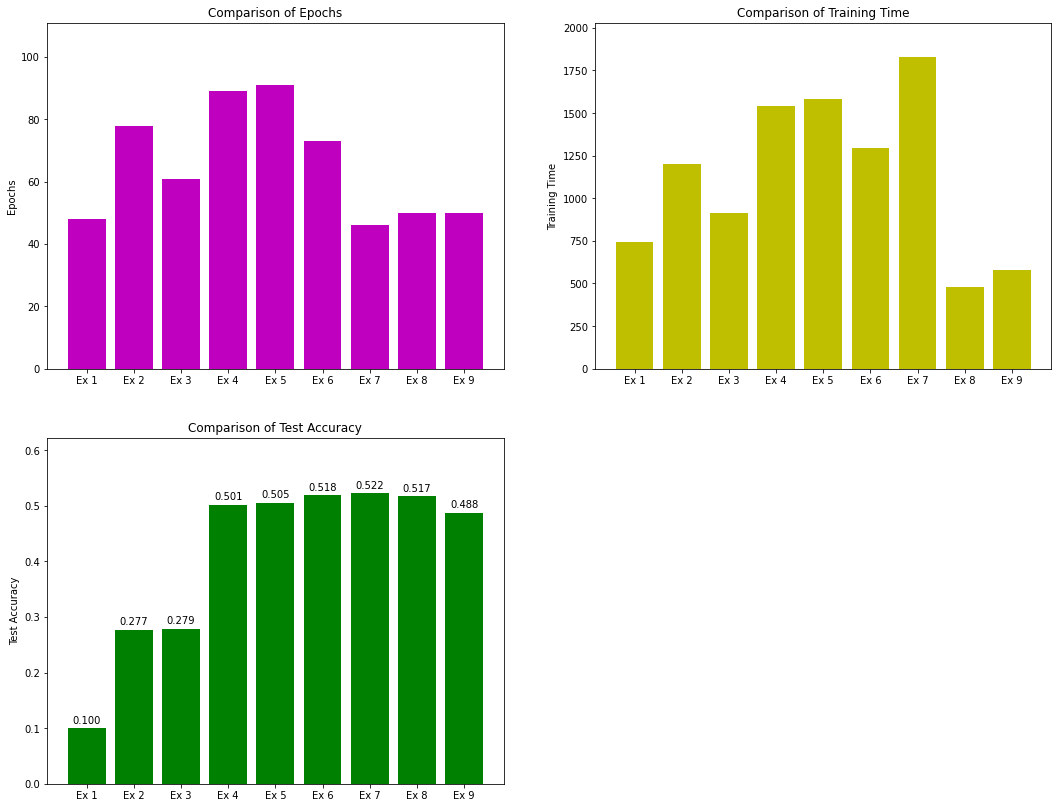

In [44]:
plt.figure(figsize=(18,14))

labels_true = ["LeCun+Sigmoid+NAdam", "LeCun+Tanh+NAdam", "Glorot+Tanh+NAdam", 
               "He+ReLU+NAdam+l2", "He+ELU+NAdam+l2", "Orthogonal+ELU+NAdam+l2", "He+ELU+NAdam+BN", "Orthogonal+ELU+1cycle+l2"]


labels = ["Ex 1", "Ex 2", "Ex 3", "Ex 4", "Ex 5", "Ex 6", "Ex 7", "Ex 8", "Ex 9"]

epochs_num= [numOfEpochs_LeCun_Sigmoid, numOfEpochs_LeCun_Tanh, numOfEpochs_Glorot_Tanh, 
             numOfEpochs_He_ReLU, numOfEpochs_He_ELU, numOfEpochs_Orthogonal_ELU, numOfEpochs_He_ELU_BN, 
             numOfEpochs_Orthogonal_ELU_1cycle, numOfEpochs_FineTuning_1cycle]

duration_num = [duration_LeCun_Sigmoid_sec, duration_LeCun_Tanh_sec, duration_Glorot_Tanh_sec, 
                duration_He_ReLU_sec, duration_He_ELU_sec, duration_Orthogonal_ELU_sec, 
                duration_He_ELU_BN_sec, duration_Orthogonal_ELU_1cycle_sec,
               (duration_Pretraining_1cycle_sec + duration_FineTuning_1cycle_sec)]

test_acc = [test_accuracy_LeCun_Sigmoid, test_accuracy_LeCun_Tanh, test_accuracy_Glorot_Tanh, test_accuracy_He_ReLU, 
            test_accuracy_He_ELU, test_accuracy_Orthogonal_ELU, test_accuracy_He_ELU_BN, test_accuracy_Orthogonal_ELU_1cycle,
           test_accuracy_FineTuning_1cycle]


plt.subplot(221)
plt.ylabel("Epochs")
plt.title("Comparison of Epochs")
plt.ylim(0, max(epochs_num)+20)
rects1=plt.bar(labels, epochs_num, color="m")

plt.subplot(222)
plt.ylabel("Training Time")
plt.title("Comparison of Training Time")
plt.ylim(0, max(duration_num)+200)
rects2=plt.bar(labels, duration_num, color="y")

plt.subplot(223)
plt.ylabel("Test Accuracy")
plt.title("Comparison of Test Accuracy")
plt.ylim(0, max(test_acc)+0.1)
rects3=plt.bar(labels, test_acc, color="g")

             
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects3)

plt.show()

## Comparative Analysis


Below we compare the performance of nine approaches based on the results obtained from the following experiments:
1. Experiment 1: LeCun Initializer + Sigmoid Activation + NAdam Optimizer
2. Experiment 2: LeCun Initializer + Tanh Activation + NAdam Optimizer
3. Experiment 3: Glorot Initializer + Tanh Activation + NAdam Optimizer
4. Experiment 4: He Initializer + ReLU Activation + NAdam Optimizer
5. Experiment 5: He Initializer + ELU Activation + NAdam Optimizer
6. Experiment 6:  Orthogonal + ELU Activation + NAdam Optimizer
7. Experiment 7: He Initializer + ELU Activation + NAdam Optimizer + BN
8. Experiment 8: Orthogonal Initializer + ELU Activation + 1cycle Learning Schedule
9. Experiment 9: Pretraining Initializer + ELU Activation + 1cycle Learning Schedule

We observe that overall the **orthogonal initializer** along with ELU activation and 1cycle learning schedule (experiment 8) performs better than other techniques. It is both effective (test accuracy is similar to that of the highest test accuracy of BN from experiment 7) and efficient (fastest training time).

Experiment 6 (orthogonal initializer + ELU + NAdam) shares the same setting with experiment 8, except that instead of 1cycle learning schedule it used the fast optimizer NAdam. As a result, the test accuracy of experiment 8 and 6 are almost identical. However, experiment 6 converges much slowly. Although NAdam updates learning rates per dimension, it doesn't improve convergence speed. It requires a larger number of epochs to converge.

The **the Batch Normalization** based technique (experiment 7) has the highest test accuracy and it trains the model in **fewest epochs** of all. However, its per epoch training time is much longer, which results into longer training time (wall time). 

The **pretraining based initialization** technique (experiment 9) is atrractive for its faster speed (its the second fastest technique) and high test accuracy. To pretrain the model we used the setting of experiment 8 (i.e., orthogonal initializer, ELU & 1cycle). We experimented with other initializers for pretraining, but orthogonal initializer turned out to be the best. Also 1cycle schedule performed better than NAdam for faster convergence.

The pretraining based technique doesn't provide any benefit (test accuracy or speed of convergence) over the orthogonal initializer based technique, at least not in the context of this dense DNN. However, in the next notebook we will see that in Convolutional Neural Networks (CNNs) the pretraining based weight initialization converges faster than orthogonal initialization providing a good enough high test accuracy.


Experiment 4 (He + ReLU) and 5 (He + ELU) seem like twin siblings. Both perform equally well, but not better than the above 3 techniques. Also they require larger time to converge.

Experiment 1 (LeCun + Sigmoid), 2 (LeCun + Tanh) and 3 (Glorot + Tanh) don't perform well, as expected. These techniques are unable to combat the vanishing/exploding gradient problem at all.

In summary, we don't find the BN based technique attractive due to its inefficiency. Although it provides the highest test accuracy, its training time is comparatively larger than the Orthogonal initializer based technique with closest test accuracy. The goal of this notebook was to find a technique that is both effective and efficient. Finally, we see that the following choices for the three factors give optimal performance in training dense DNNs:
- Weight initializer: orthogonal
- Activation: ELU
- SGD learning rate: 1cycle 


           We are curious to see whether these choices are the same in CNNs. We will get this answer from the next notebook.